Group project for ML course, authors: Joanna Mielniczuk, Szymon Kiczak, Magdalena Jarecka

Aim: checking whether we can discover genre of a book via various methods

In [ ]:
import pandas as pd
import io  
from google.colab import files
import re
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.model_selection import train_test_split
from random import choice
from PIL import Image, ImageStat, ImageEnhance

Upload dataset file here:

In [ ]:
uploaded = files.upload()

MessageError: ignored

In [ ]:
columns = [
    "image",
    "name",
    "author",
    "format",
    "book_depository_stars",
    "price",
    "currency",
    "old_price",
    "isbn",
    "category",
    "img_paths"
]
books_df  = pd.read_csv('book_dataset.csv')
#books_df = pd.read_csv(io.BytesIO(uploaded["book_dataset.csv"]), header=0, names=columns)
del books_df["format"]
del books_df["price"]
del books_df["currency"]
del books_df["old_price"]
del books_df["isbn"]
del books_df["image"]
del books_df["book_depository_stars"]
books_df.head()

,name,author,category,img_paths
0,This is Going to Hurt,Adam Kay,Medical,dataset/Medical/0000001.jpg
1,"Thinking, Fast and Slow",Daniel Kahneman,Medical,dataset/Medical/0000002.jpg
2,When Breath Becomes Air,Paul Kalanithi,Medical,dataset/Medical/0000003.jpg
3,The Happiness Trap,Russ Harris,Medical,dataset/Medical/0000004.jpg
4,Man's Search For Meaning,Viktor E. Frankl,Medical,dataset/Medical/0000005.jpg


Finding most frequent words

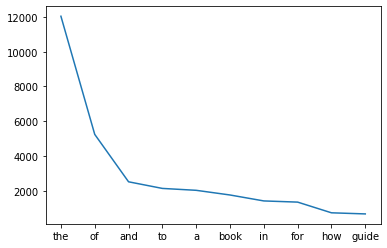

In [ ]:
def mostFrequentWords(data, n):
    words = {}
    for i in data['name']:
        splitted = i.split()

        for j in splitted:
            w = re.sub('[^a-z]+', '', j.lower())
            if w != '':
                if w in words.keys():
                    words[w] += 1
                else:
                    words[w] = 1

    words = {k: v for k, v 
             in sorted(words.items(), key=lambda item: item[1], reverse=True)}
    names = list(words.keys())[:n]
    values = list(words.values())[:n]

    plt.plot(names, values)
    return names

notAllowedWords = mostFrequentWords(books_df, 10)
alsoMeaningless = ['a', 'is', 'are', 'the', 'of', 'and', 'to', 'be', 'this']
notAllowedWords += alsoMeaningless

Cleaning titles from most frequent words

In [ ]:
def cleanTitle(title):
    titleWords = title.split()
    titleWords = list(map(
        lambda w: re.sub('[^a-z]+', '', w.lower()),
        titleWords))

    titleWords = [w for w in titleWords
                  if w not in notAllowedWords]

    return ' '.join(titleWords)

books_df["name"] = books_df["name"].apply(cleanTitle)
books_df.head()

,name,author,category,img_paths
0,going hurt,Adam Kay,Medical,dataset/Medical/0000001.jpg
1,thinking fast slow,Daniel Kahneman,Medical,dataset/Medical/0000002.jpg
2,when breath becomes air,Paul Kalanithi,Medical,dataset/Medical/0000003.jpg
3,happiness trap,Russ Harris,Medical,dataset/Medical/0000004.jpg
4,mans search meaning,Viktor E. Frankl,Medical,dataset/Medical/0000005.jpg


# Images

In [ ]:
images = files.upload()

Saving dataset.zip to dataset (1).zip


In [ ]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Mind-Body-Spirit/0000902.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000902.jpg  
  inflating: dataset/Mind-Body-Spirit/0000916.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000916.jpg  
  inflating: dataset/Mind-Body-Spirit/0000137.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000137.jpg  
  inflating: dataset/Mind-Body-Spirit/0000889.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000889.jpg  
  inflating: dataset/Mind-Body-Spirit/0000651.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000651.jpg  
  inflating: dataset/Mind-Body-Spirit/0000645.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000645.jpg  
  inflating: dataset/Mind-Body-Spirit/0000123.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000123.jpg  
  inflating: dataset/Mind-Body-Spirit/0000679.jpg  
  inflating: __MACOSX/dataset/Mind-Body-Spirit/._0000679.jpg  
  inflating: dataset/Mind-Bod

In [ ]:
def tohex(colorlist):
    return int(colorlist[0]) * 256 * 256 + int(colorlist[1]) * 256 + int(colorlist[2])

def getAvgMedian(file):
    stats = ImageStat.Stat(file)
    #print(f"mean:{stats.mean}, median:{stats.median}")
    return tohex(stats.mean), tohex(stats.median)

def getBrightness(file):
    greyscaleImage = file.convert('L')
    histogram = greyscaleImage.histogram()
    pixels = sum(histogram)
    brightness = scale = len(histogram)

    for index in range(0, scale):
        ratio = histogram[index] / pixels
        brightness += ratio * (-scale + index)

    return 1 if brightness == 255 \
        else brightness / scale

def getDominantColor(file, palette_size=16):
    # resize image to speed up processing
    image = file.copy()
    image.thumbnail((100, 100))

    # reduce colors (uses k-means internally)
    paletted = image.convert('P', palette=Image.ADAPTIVE, colors=palette_size)

    # find the color that occurs most often
    palette = paletted.getpalette()
    colorCounts = sorted(paletted.getcolors(), reverse=True)
    paletteIndex = colorCounts[0][1]
    dominantColor = palette[paletteIndex*3:paletteIndex*3+3]

    return dominantColor

def lessColors(file, r=64):
    return file.quantize(colors=r) #24?

In [ ]:
def analyzeImage(filename, reduction=24):
    file = Image.open(filename)
    print(f"filename:{filename}, getbands:{file.getbands()}")
    reducedFile = lessColors(file, reduction).convert("RGB")
    #print(f"reducedfile getbands:{reducedFile.getbands()}")
    avgColor, medianColor = getAvgMedian(reducedFile)
    dominantColor = tohex(getDominantColor(reducedFile))

    brightness = getBrightness(file)

    histogram = file.histogram()
    veryOften = len([x for x in histogram if x > 1500])
    
    lessColorsFile = lessColors(file).convert("RGB")
    lessColorsHist = lessColorsFile.histogram()
    lessOften = len([x for x in lessColorsHist if x > 900])

    # avarage color, median color (3-element lists)
    # number of very-often appearing colors, ... less often ...
    # brightness (from 0 to 1)
    # dominant color
    return avgColor, medianColor, veryOften, lessOften, brightness, dominantColor

In [ ]:
def applyAndConcat(df, col, func, names):
    return pd.concat((df,df[col].apply(
        lambda cell: pd.Series(func(cell), index=names))), axis=1)

In [ ]:
books_df = applyAndConcat(books_df, 'img_paths', analyzeImage,
['avg_color', 'median_color', 'num_of_popular_colors', 'num_of_less_popular_colors', 'brightness', 'dominant_color'])

books_df.head()

Streaming output truncated to the last 5000 lines.
filename:dataset/Entertainment/0000361.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000362.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000363.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000364.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000365.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000366.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000367.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000368.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000369.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000370.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000371.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000372.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000373.jpg, getbands:('R', 'G', 'B')
filename:dataset/Entertainment/0000374.jpg, getbands

#Titles (Naive Bayes)

In [ ]:
train, test = train_test_split(books_df, test_size=0.1)

#train = books_df
#_, test = train_test_split(books_df, test_size=0.3)

In [ ]:
def allWordCombos(title, n=2):
    titleWords = title.split()
    if n == 1:
        return titleWords

    return list(it.combinations(titleWords, r=n))

In [ ]:
def gatherInfo(dataset, n):
    all = set()
    categoryCounts = dict()

    def add2Counts(cat, word):
        if cat not in categoryCounts.keys():
            categoryCounts[cat] = dict()

        if word not in categoryCounts[cat].keys():
            categoryCounts[cat][word] = 1
        else:
            categoryCounts[cat][word] += 1

    for i, row in dataset.iterrows():
        cat = row['category']
        title = row['name']
        combos = allWordCombos(title, n)

        for c in combos:
            if c not in all:
                all.add(c)
            add2Counts(cat, c)
    
    return categoryCounts, list(all)

In [ ]:
def createProbTable(dataset, n):
    result = dict()
    counts, all = gatherInfo(dataset, n)
    categories = list(counts.keys())
    catSums = [sum(counts[c].values()) for c in categories]

    for cat in categories:
        result[cat] = []

    for combo in all:
        for cat, s in zip(categories, catSums):
            if combo not in counts[cat].keys():
                prob = 0
            else:
                prob = counts[cat][combo] / s
            result[cat].append(prob)

    return pd.DataFrame(result, index=all)


In [ ]:
singleWordProbs = createProbTable(train, 1)
singleWordProbs.head()

,Science-Geography,Personal-Development,Crafts-Hobbies,Dictionaries-Languages,Natural-History,Reference,Health,Sport,Humour,Science-Fiction-Fantasy-Horror,Biography,Teaching-Resources-Education,Technology-Engineering,Home-Garden,Poetry-Drama,Transport,Stationery,History-Archaeology,Crime-Thriller,Childrens-Books,Food-Drink,Graphic-Novels-Anime-Manga,Teen-Young-Adult,Mind-Body-Spirit,Medical,Society-Social-Sciences,Religion,Business-Finance-Law,Art-Photography,Computing,Romance,Travel-Holiday-Guides,Entertainment
hanon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.001327,0.0,0.0,0.000000,0.001537
beijing,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000351,0.000000
hamster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000337,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000344,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
nuance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000302,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000399,0.000000,0.0,0.0,0.000000,0.000000
sixty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000674,0.0,0.0,0.000000,0.0,0.0,0.0,0.000335,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [ ]:
doubleWordProbs = createProbTable(train, 2)
doubleWordProbs.head()

,Science-Geography,Personal-Development,Crafts-Hobbies,Dictionaries-Languages,Natural-History,Health,Sport,Reference,Humour,Science-Fiction-Fantasy-Horror,Biography,Teaching-Resources-Education,Technology-Engineering,Home-Garden,Poetry-Drama,Transport,History-Archaeology,Crime-Thriller,Childrens-Books,Food-Drink,Graphic-Novels-Anime-Manga,Teen-Young-Adult,Mind-Body-Spirit,Medical,Society-Social-Sciences,Religion,Business-Finance-Law,Art-Photography,Computing,Romance,Stationery,Travel-Holiday-Guides,Entertainment
"(subject, with)",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000204,0.0,0.0,0.0,0.000155,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
"(systems, life)",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000351,0.0,0.0,0.0,0.0
"(ii, sat)",0.0,0.0,0.0,0.000125,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000155,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
"(on, smith)",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000176,0.0,0.0,0.0,0.0
"(right, chickens)",0.0,0.0,0.0,0.000000,0.000271,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
tripleWordProbs = createProbTable(train, 3)
tripleWordProbs.head()

,Science-Geography,Personal-Development,Crafts-Hobbies,Dictionaries-Languages,Health,Sport,Reference,Humour,Teaching-Resources-Education,Home-Garden,Poetry-Drama,Transport,History-Archaeology,Crime-Thriller,Science-Fiction-Fantasy-Horror,Food-Drink,Graphic-Novels-Anime-Manga,Teen-Young-Adult,Childrens-Books,Medical,Natural-History,Society-Social-Sciences,Religion,Business-Finance-Law,Computing,Mind-Body-Spirit,Romance,Travel-Holiday-Guides,Stationery,Biography,Entertainment,Technology-Engineering,Art-Photography
"(pascales, fresh, easy)",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00022,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"(myths, classics, deluxe)",0.0,0.0,0.0,0.000000,0.0,0.0,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"(sell, revised, expanded)",0.0,0.0,0.0,0.000065,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
"(encyclopedia, components, lcds)",0.0,0.0,0.0,0.000000,0.0,0.0,0.000132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000157,0.0
"(island, blue, dolphins)",0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000173,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
single_log = singleWordProbs.applymap(lambda p:
                      np.log(p + 1e-100) if p != 0 
                      else p)

double_log = doubleWordProbs.applymap(lambda p:
                      np.log(p + 1e-100) if p != 0 
                      else p)

triple_log = tripleWordProbs.applymap(lambda p:
                      np.log(p + 1e-100) if p != 0 
                      else p)

In [ ]:
def naive_bayes(title, categories):
    singleProbs = {}
    doubleProbs = {}
    tripleProbs = {}

    # cleaning from unknown words
    titleWords = title.split()
    titleWords = list(filter(
        lambda w: w in singleWordProbs.index,
        titleWords))
    titleCombos2 = allWordCombos(' '.join(titleWords), 2)
    titleCombos3 = allWordCombos(' '.join(titleWords), 3)
    
    for cat in categories:
        # single
        s = np.sum([single_log[cat][w] for w in titleWords])
        if s == 0:
            singleProbs[cat] = 0
        else: 
            singleProbs[cat] = np.exp(s) / len(categories)

        # double 
        s = np.sum([double_log[cat][w] if w in double_log[cat].keys() 
                    else 0 
                    for w in titleCombos2])
        if s == 0:
            doubleProbs[cat] = 0
        else: 
            doubleProbs[cat] = np.exp(s) / len(categories)

        # triple
        s = np.sum([triple_log[cat][w] if w in triple_log[cat].keys() 
                    else 0 
                    for w in titleCombos3])
        if s == 0:
            tripleProbs[cat] = 0
        else: 
            tripleProbs[cat] = np.exp(s) / len(categories)


    singleSum = np.sum(list(singleProbs.values()))
    doubleSum = np.sum(list(doubleProbs.values()))
    tripleSum = np.sum(list(tripleProbs.values()))

    singleProbs = sorted(singleProbs.items(), key=lambda item: item[1], reverse=True)
    doubleProbs = sorted(doubleProbs.items(), key=lambda item: item[1], reverse=True)
    tripleProbs = sorted(tripleProbs.items(), key=lambda item: item[1], reverse=True)

    sp = {k: v / singleSum for k, v in singleProbs}
    dp = {k: v / doubleSum for k, v in doubleProbs}
    tp = {k: v / tripleSum for k, v in tripleProbs}

    return sp, dp, tp

In [ ]:
_, samples = train_test_split(train, test_size=0.1)


#X = samples['name']
#Y = samples['category']

X = test['name']
Y = test['category']
categories = singleWordProbs.columns

singlePreds = []
doublePreds = []
triplePreds = []

for title, target in zip(X, Y):
    sp, dp, tp = naive_bayes(title, categories)
    singleBest, singleBestProb = list(sp.items())[0]
    doubleBest, doubleBestProb = list(dp.items())[0]
    tripleBest, tripleBestProb = list(tp.items())[0]

    singlePreds.append((singleBest, singleBestProb))
    doublePreds.append((doubleBest, doubleBestProb))
    triplePreds.append((tripleBest, tripleBestProb))

    print('{0}: single: {1} ({2}), double: {3} ({4}), triple: {5} ({6}) - correct: {7}'.format(
        title, 
        singleBest, singleBestProb, 
        doubleBest, doubleBestProb, 
        tripleBest, tripleBestProb,
        target))

singleErr = np.sum([t[0] for t in singlePreds] != Y) / len(Y)
doubleErr = np.sum([t[0] for t in doublePreds] != Y) / len(Y)
tripleErr = np.sum([t[0] for t in triplePreds] != Y) / len(Y)
print('Single err: ', singleErr)
print('Double err: ', doubleErr)
print('Triple err: ', tripleErr)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in long_scalars


frame life  designs studioilse: single: Biography (0.08494903662070916), double: Science-Geography (nan), triple: Science-Geography (nan) - correct: Home-Garden
lab girl: single: Crime-Thriller (0.25523135231021327), double: Biography (1.0), triple: Science-Geography (nan) - correct: Natural-History
etymologicon: single: Science-Geography (nan), double: Science-Geography (nan), triple: Science-Geography (nan) - correct: Dictionaries-Languages
mamba mentality: single: Sport (1.0), double: Sport (1.0), triple: Science-Geography (nan) - correct: Biography
fighters mind: single: Mind-Body-Spirit (0.12384051282726474), double: Science-Geography (nan), triple: Science-Geography (nan) - correct: Sport
leonardo da vinci: single: Crime-Thriller (0.9960351818003145), double: Crime-Thriller (0.9999994046090849), triple: Biography (0.40335066933514074) - correct: Biography
happier hour: single: Business-Finance-Law (0.1742032332016745), double: Health (1.0), triple: Science-Geography (nan) - corre

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


shape by shape  collection : single: Romance (0.1688190271437558), double: Graphic-Novels-Anime-Manga (0.9999999999881013), triple: Crafts-Hobbies (1.0) - correct: Crafts-Hobbies
ladybird red tape: single: Crime-Thriller (0.17288589265262422), double: Transport (0.9999998935991248), triple: Humour (0.6110630942091616) - correct: Society-Social-Sciences
aspergirls: single: Society-Social-Sciences (0.5161030595813204), double: Science-Geography (nan), triple: Science-Geography (nan) - correct: Health
being mortal: single: Personal-Development (0.15194240924830582), double: Medical (0.5088323110936877), triple: Science-Geography (nan) - correct: Health
cherub recruit: single: Teen-Young-Adult (0.9086394306930815), double: Childrens-Books (1.0), triple: Science-Geography (nan) - correct: Teen-Young-Adult
fire blood: single: History-Archaeology (0.39460142659140707), double: Science-Geography (nan), triple: Science-Geography (nan) - correct: Science-Fiction-Fantasy-Horror
food trails: singl

# Decision trees

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt

In [ ]:
data4tree = books_df[['avg_color', 'median_color', 'num_of_popular_colors', 'num_of_less_popular_colors', 'brightness', 'dominant_color', 'category']]
data4tree

,avg_color,median_color,num_of_popular_colors,num_of_less_popular_colors,brightness,dominant_color,category
0,5078927.0,4487056.0,1.0,18.0,0.444851,5065551.0,Medical
1,15066335.0,16447989.0,10.0,18.0,0.889368,16447989.0,Medical
2,7702436.0,7768492.0,0.0,24.0,0.519732,8428996.0,Medical
3,15460827.0,16449017.0,8.0,25.0,0.903085,16777215.0,Medical
4,9405061.0,10128786.0,0.0,2.0,0.526763,4010038.0,Medical
...,...,...,...,...,...,...,...
32576,14067804.0,16034620.0,5.0,37.0,0.673341,16426777.0,Travel-Holiday-Guides
32577,7826508.0,7300930.0,0.0,19.0,0.421651,7165734.0,Travel-Holiday-Guides
32578,13408409.0,13743274.0,5.0,21.0,0.654781,12001320.0,Travel-Holiday-Guides
32579,8943713.0,8349516.0,0.0,25.0,0.477086,6315861.0,Travel-Holiday-Guides


In [ ]:
def createCatDict(df):
    result = dict()
    n = 1
    for i, row in df.iterrows():
        cat = row['category']
        if cat not in result.keys():
            result[cat] = n
            n += 1

    return result

categoryMap = createCatDict(data4tree)

def mapCat(cat):
    if cat in categoryMap.keys():
        return categoryMap[cat]
    else:
        return 0

In [ ]:
def mapBrightness(brightness):
    return round(brightness / 0.2)

In [ ]:
pd.options.mode.chained_assignment = None
data4tree['category'] = data4tree['category'].apply(mapCat)
data4tree['brightness'] = data4tree['brightness'].apply(mapBrightness)
data4tree.head()

,avg_color,median_color,num_of_popular_colors,num_of_less_popular_colors,brightness,dominant_color,category
0,5078927.0,4487056.0,1.0,18.0,2,5065551.0,1
1,15066335.0,16447989.0,10.0,18.0,4,16447989.0,1
2,7702436.0,7768492.0,0.0,24.0,3,8428996.0,1
3,15460827.0,16449017.0,8.0,25.0,5,16777215.0,1
4,9405061.0,10128786.0,0.0,2.0,3,4010038.0,1


In [ ]:
X = data4tree[['avg_color', 'median_color', 'num_of_popular_colors', 'num_of_less_popular_colors', 'brightness', 'dominant_color']]
Y = data4tree['category']

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.1)

In [ ]:
clf = DecisionTreeClassifier(splitter='best', max_depth = None, random_state=0)#, ccp_alpha=0.00007)
clf.fit(train_X, train_Y)

#plt.figure(figsize=(250, 100))
#tree.plot_tree(clf, fontsize=50,label="none")
#plt.show()

DecisionTreeClassifier(random_state=0)

In [ ]:
print(clf.score(train_X, train_Y))
print(clf.score(test_X, test_Y))
predictedY = clf.predict(test_X)
print(predictedY)

0.7171748175431417
0.027922675667382633
[19 21  1 ... 10  4 23]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
forestclf = RandomForestClassifier(n_estimators=30, max_samples = 1000)
forestclf.fit(train_X, train_Y)
print(forestclf.score(test_X, test_Y))

0.050935869898741944


3789
[0.00000000e+00 3.81640959e-05 3.81640959e-05 ... 1.13690746e-03
 1.36157347e-03 1.59795722e-03]


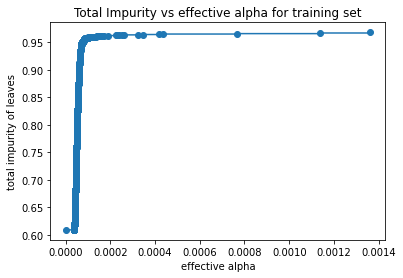

In [ ]:
clf = DecisionTreeClassifier(splitter='best', max_depth = None, max_leaf_nodes=7000, random_state=0)
clf.fit(train_X, train_Y)
path = clf.cost_complexity_pruning_path(train_X, train_Y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
print(len(ccp_alphas))
print(ccp_alphas)

0, 0.0
1, 3.816409586820875e-05
2, 3.816409586820886e-05
3, 3.816409586820886e-05
4, 3.823791423545871e-05
5, 3.823791423545871e-05
6, 3.823791423545871e-05
7, 3.823791423545871e-05
8, 3.823791423545876e-05
9, 3.823791423545876e-05
10, 3.823791423545876e-05
11, 3.827898963853875e-05
12, 3.8301511598012514e-05
13, 3.835287053595909e-05
14, 3.836709637814611e-05
15, 3.836709637814611e-05
16, 3.8434763214791827e-05
17, 3.8434763214791827e-05
18, 3.8434763214791827e-05
19, 3.8434763214791827e-05
20, 3.8434763214791827e-05
21, 3.8434763214791827e-05
22, 3.8434763214791827e-05
23, 3.8434763214791827e-05
24, 3.8434763214791827e-05
25, 3.8434763214791827e-05
26, 3.8434763214791827e-05
27, 3.8434763214791827e-05
28, 3.8434763214791827e-05
29, 3.8434763214791827e-05
30, 3.8434763214791827e-05
31, 3.8434763214791827e-05
32, 3.8434763214791827e-05
33, 3.8434763214791827e-05
34, 3.8434763214791827e-05
35, 3.844460566375851e-05
36, 3.844460566375851e-05
37, 3.844460566375851e-05
38, 3.84446056637585

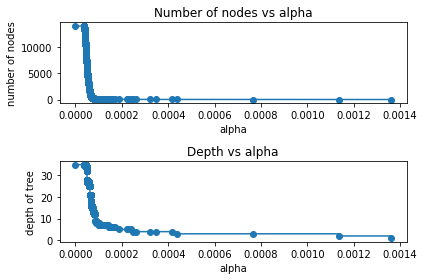

In [ ]:
clfs = []

counter = 0
for ccp_alpha in ccp_alphas:
    #if counter % 10 != 0:
    #  continue
    clf = DecisionTreeClassifier(random_state=0, max_leaf_nodes=7000, ccp_alpha=ccp_alpha)
    clf.fit(train_X, train_Y)
    clfs.append(clf)
    print(f"{counter}, {ccp_alpha}")
    counter += 1
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

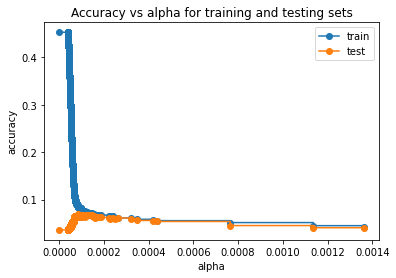

In [ ]:
train_scores = [clf.score(train_X, train_Y) for clf in clfs]
test_scores = [clf.score(test_X, test_Y) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0007)
clf.fit(train_X, train_Y)
print(clf.score(train_X, train_Y))
print(clf.score(test_X, test_Y))
predictedY = clf.predict(test_X)
print(predictedY)

0.05548734738421663
0.05369745320650506
[24 24 14 ...  7  7  7]


### Knn and Logistic Regression


In [ ]:
pip install icecream

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from icecream import ic
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def errors(test, pred):
    good = []
    i = 0
    for j in test:
        if j == pred[i]:
            good.append(1)
        else:
            good.append(0)
        i += 1
    return (sum(good)/len(good))*100

In [ ]:
df = books_df
ic(books_df.columns)
book_median = np.array(df['median_color']).reshape(-1, 1)
book_avg_col = np.array(df['avg_color']).reshape(-1, 1)
book_bright = np.array(df['brightness']).reshape(-1, 1)
book_popular_col = np.array(df['num_of_popular_colors']).reshape(-1, 1)
book_dominant = np.array(df['num_of_less_popular_colors']).reshape(-1, 1)
book_less_popular_col = np.array(df['dominant_color']).reshape(-1, 1)

categ_list = [book_median, book_avg_col, book_bright, book_popular_col, book_dominant, book_less_popular_col]
book_y = np.array(df['category'])
book_x = np.hstack([book_bright, book_popular_col, book_dominant, book_median, book_avg_col])
xtrain, xtest, ytrain, ytest = train_test_split(book_x, book_y, test_size=0.2)

k = [1, 5, 10, 15, 20, 25, 30]
ks = {}
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(xtrain, ytrain)
    ypred = knn.predict(xtest)
    ks[i] = errors(ytest, ypred)
ic(ks)

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(xtrain, ytrain)
ypred = clf.predict(xtest)
ic(errors(ytest, ypred))

NameError: ignored